In [1]:
! pip install langchain_core langchain-anthropic langgraph

In [2]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [3]:
import os, getpass

def _set_env(var:str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


In [4]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [5]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, justification="Why this query is relevant to the user's request.")

structured_llm = llm.with_structured_output(SearchQuery)

output = structured_llm.invoke("What is role of garbage collection in JS")
print(output)

search_query='how does JavaScript garbage collection work memory management role explanation' justification="This query will help find detailed information about JavaScript's garbage collection mechanism, its role in memory management, and how it automatically handles memory allocation and deallocation."


In [6]:
from langchain_core.tools import tool

@tool
def multiply(a: float, b: float) -> int:
    """Multiplies a and b."""
    return a * b

tools_map = {"multiply":multiply}
llm_with_tools = llm.bind_tools([multiply])
msg = llm_with_tools.invoke("What is 2.4321058091 times 3.1029285928?")

for tool_call in msg.tool_calls:
    selected_tool = tools_map[tool_call["name"].lower()]
    tool_message = selected_tool.invoke(tool_call)
    print(tool_message)

content='7.546650655771368' name='multiply' tool_call_id='toolu_01FfHdZp3BfDCqWnhdBruYin'


In [7]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [8]:
def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke":msg.content}

def improve_joke(state: State):
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke":msg.content}

def polish_joke(state: State):
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke":msg.content}

def check_punchline(state: State):
   if "?" in state["joke"] or "!" in state["joke"]:
       return "Pass"
   return "Fail"

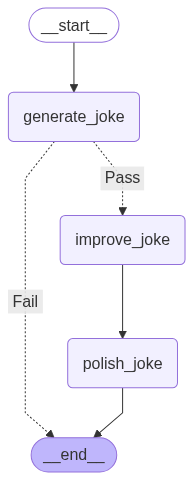

In [9]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(State)

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
                              )
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain  = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))


In [10]:
chain.invoke({"topic":"car"})

{'topic': 'car',
 'joke': "Here's a short car joke:\n\nWhy don't cars like telling jokes?\nBecause they're afraid of cracking up!",
 'improved_joke': 'Here\'s the car joke with added wordplay:\n\nWhy don\'t cars like telling jokes?\nBecause they\'re afraid of cracking up and ending up in the PUNCH-line! Besides, their humor might be too AUTO-matic, and they don\'t want to TIRE everyone out!\n\nThis version adds multiple layers of wordplay:\n- PUNCH-line (car crash/joke punchline)\n- AUTO-matic (automobile/automatic)\n- TIRE (car tire/become exhausted)\n\nPlus it still keeps the original "cracking up" double meaning (laughing/car crash)!',
 'final_joke': 'Here\'s a surprising twist added to your car joke:\n\nWhy don\'t cars like telling jokes?\nBecause they\'re afraid of cracking up and ending up in the PUNCH-line! Besides, their humor might be too AUTO-matic, and they don\'t want to TIRE everyone out!\n\n...except for the DeLorean - it\'s always trying to get laughs in the FUTURE!\n\nT

In [49]:
class State(TypedDict):
    topic: str
    poem: str
    joke: str
    puzzle: str

In [50]:
def joke_generator(state: State):
    msg = llm.invoke(f"Write a short joke about: {state["topic"]}")
    return {"joke": msg.content}
    
def poem_generator(state: State):
    msg = llm.invoke(f"Write a short poem about: {state["topic"]}")
    return {"poem": msg.content}
    
def puzzle_generator(state: State):
    msg = llm.invoke(f"Write a quirky short puzzle about: {state["topic"]}")
    return {"puzzle": msg.content}

def aggregator(state: State):
    combined = f"Here's a joke, poem and puzzle about {state["topic"]} \n\n"
    combined += f"Joke: {state["joke"]} \n\n"
    combined += f"Poem: {state["poem"]} \n\n"
    combined += f"Puzzle: {state["puzzle"]} \n\n"
    return {"combined_output":combined}

In [51]:
! pip install --quiet pyppeteer
! pip install --quiet nest_asyncio

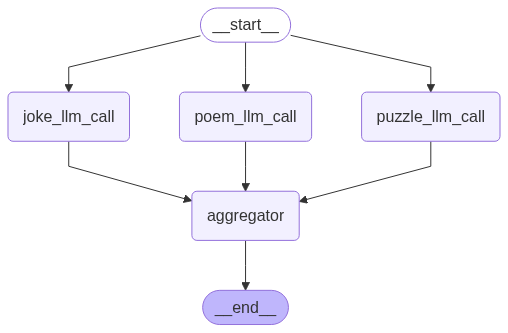

{'topic': 'car',
 'poem': "Here's a short poem about a car:\n\nSteel and chrome, a faithful friend,\nFour wheels turning, miles to spend.\nEngine purring, steering true,\nTaking me from old to new.\n\nThrough rain and shine, day and night,\nDown winding roads, pure delight.\nMy trusty car, faithful guide,\nAdventure waiting, let's take a ride.",
 'joke': "Here's a short car joke:\n\nWhat kind of car does a sneezing driver have?\n\nA-choo-di! (Audi)",
 'puzzle': "Here's a quirky car puzzle:\n\nI purr but have no fur,\nI have a trunk but cannot climb,\nI have keys but no locks to mind,\nI drink but never eat,\nI have a hood but no head underneath.\nWhat am I?\n\nAnswer: A car! 🚗\n\nThe puzzle plays with common car features that share names with other objects:\n- Engine purr (like a cat)\n- Car trunk (unlike a tree/elephant trunk)\n- Car keys (not door keys)\n- Drinks fuel (not water/beverages)\n- Car hood (not a clothing hood)"}

In [52]:
import nest_asyncio
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
nest_asyncio.apply()

parallel_builder = StateGraph(State)

parallel_builder.add_node("joke_llm_call", joke_generator)
parallel_builder.add_node("poem_llm_call", poem_generator)
parallel_builder.add_node("puzzle_llm_call", puzzle_generator)
parallel_builder.add_node("aggregator", aggregator)

parallel_builder.add_edge(START, "joke_llm_call")
parallel_builder.add_edge(START, "poem_llm_call")
parallel_builder.add_edge(START, "puzzle_llm_call")

parallel_builder.add_edge("joke_llm_call", "aggregator")
parallel_builder.add_edge("poem_llm_call", "aggregator")
parallel_builder.add_edge("puzzle_llm_call", "aggregator")

parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

display(Image(parallel_workflow.get_graph().draw_mermaid_png())) 

parallel_workflow.invoke({"topic":"car"})


In [53]:
from typing_extensions import Literal
class State(TypedDict):
    decision: str
    input: str
    output: str
    
class Route(BaseModel):
    step: Literal["poem", "story", "puzzle"] = Field(None, description="The next step in the routing process")

router = llm.with_structured_output(Route)

In [54]:
from langchain_core.messages import HumanMessage, SystemMessage
def llm_call_1(state: State):
    print("Writing a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    print("Writing a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    print("Writing a puzzle")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):

    decision  = router.invoke([
        SystemMessage(content="Route the input to story, poem or puzzle based on user's request"),
        HumanMessage(content=state["input"])
    ])
    print(decision)
    return {"decision":decision.step}

def route_decision(state: State):
    match state["decision"]:
        case "story":
            return "llm_call_1"
        case "poem":
            return "llm_call_2"
        case "puzzle":
            return "llm_call_3"
   

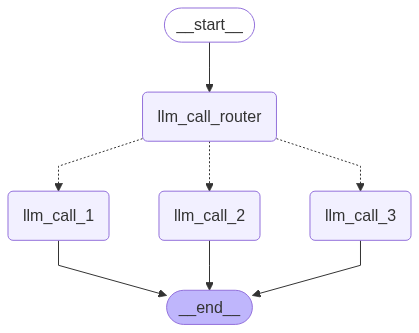

In [55]:
router_builder = StateGraph(State)

router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges("llm_call_router", route_decision, {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    })
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png())) 


In [56]:
state = router_workflow.invoke({"input":"Write me joke about cars"})
print(state["output"])

step='story'
Writing a story
Here's a car joke for you:

Why don't cars like telling jokes?

Because they're afraid of cracking up! 

Here's another one:
What kind of car does a snake drive?
An Ana-conda Civic!


In [61]:
from langchain_core.tools import tool

@tool
def mul(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a*b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b

    Args:
        a: first int
        b: second int
    """
    return a+b  

@tool
def divide(a: int, b: int) -> int:
    """Dividees a and b

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [mul, add, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
    

In [102]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage
from langchain_core.messages import HumanMessage, SystemMessage

#Node definitions
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages":[
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithematic on set of inputs"
                    ) 
                ]+ state["messages"]
            )
        ]
    }
def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state:MessagesState)-> Literal["environment", END]:
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "Action"
    return END

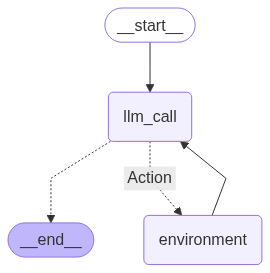

In [103]:


agent_builder = StateGraph(MessagesState)
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {"Action":"environment", END:END})
agent_builder.add_edge("environment", "llm_call")

agent = agent_builder.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [107]:


messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiply by 9")]
messages = agent.invoke({"messages":messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiply by 9
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation. Let's break this down into steps:\n\n1. First, let's add 3 and 4:", 'type': 'text'}, {'id': 'toolu_011eavsv8GG69hbxRH3T2Rtm', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_011eavsv8GG69hbxRH3T2Rtm)
 Call ID: toolu_011eavsv8GG69hbxRH3T2Rtm
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

[{'text': "2. Now, let's multiply the result (7) by 9:", 'type': 'text'}, {'id': 'toolu_01URkCX2NQPzs6jqVdipUSKj', 'input': {'a': 7, 'b': 9}, 'name': 'mul', 'type': 'tool_use'}]
Tool Calls:
  mul (toolu_01URkCX2NQPzs6jqVdipUSKj)
 Call ID: toolu_01URkCX2NQPzs6jqV